In [134]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [135]:
# parameters
M = 20       # feature dimensionality
N = 100      # number of observations
sigma = 0.1  # the noise standard deviation
lam = 0.1    # the regularisation coefficient

In [136]:
# the ground truth process
x = np.linspace(-10, 10, 100)
f = np.sin(x)
n = np.random.normal(size=100, scale=sigma)
y = f + n
# construct the design matrix
Phi = np.array([[np.exp(- (xx - mu) ** 2)  for mu in np.linspace(-10, 10, M)] for xx in x])

## Maximum Likelihood Estimation

In [137]:
def ml_estimate(D, reg=0.):
    """Given a dataset D = (phi, y) generate the maximum 
    likelihood estimate for w"""
    Phi, y, *_ = D
    w = np.linalg.inv(reg * np.eye(M) + Phi.T @ Phi) @ Phi.T @ y
    return w

In [138]:
# estimate w
w = ml_estimate((Phi, y))
fm = Phi @ w

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


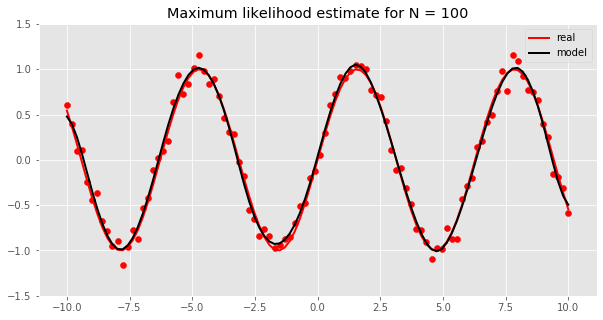

In [139]:
# generate figure
fig = plt.figure(figsize=[10., 5.])
plt.title(f'Maximum likelihood estimate for N = {N}')
plt.plot(x, f, 'r', linewidth=2.0)
plt.plot(x, fm, 'k', linewidth=2.0)
plt.ylim([-1.5, 1.5])
plt.scatter(x, y, c='r')
plt.legend(['real', 'model'])
# plt.show()
plt.savefig('ml-100.eps')

### Overfitting
What happens if we reduce N? In this case we are more likely to overfit...

In [140]:
import random
def sample(D, n=30):
    choice = random.sample(range(100), n)
    return [x[choice] for x in D]

In [141]:
# Lets make N smaller
N = 20
D = sample((Phi, y, x), n=N)
w = ml_estimate(D)
fm = Phi @ w

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


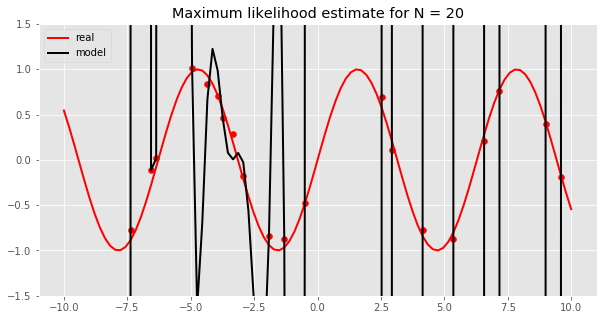

In [142]:
# generate figure
fig = plt.figure(figsize=[10., 5.])
plt.title(f'Maximum likelihood estimate for N = {N}')
plt.plot(x, f, 'r', linewidth=2.0)
plt.plot(x, fm, 'k', linewidth=2.0)
plt.ylim([-1.5, 1.5])
plt.scatter(D[-1], D[-2], c='r')
plt.legend(['real', 'model'])
plt.savefig('ml-20.eps')

## Regularisation - a frequentist point of view

In [124]:
# Useful statistics. Here f_ has shape [K, M] giving different
# estimates for f using K different datasets.
# Here fm = np.mean(f_, -1) averaged for different values of input.
#
# loss = likelihood + reg * w.T @ w

def sq_bias(f, fm):
    """How far the expected estimated function fm falls from the
    true function f."""
    return np.mean((f - fm) ** 2)

def var(f_, fm):
    """The variance in the function estimate 
    for different datasets."""
    fm = fm.reshape(f_.shape[0], 1)
    return np.mean((f_ - fm) ** 2)

def mse(f, f_):
    """The average error between each predicted 
    function and the true function value."""
    f = f.reshape(f_.shape[0], 1)
    return np.mean((f - f_) ** 2)

In [125]:
# find the ml estimate for different datasets
# of N=20 samples for different values of 
# regularisation.
N = 20
T = 200
reg = np.array([0.001, 0.01, 0.03, 0.08, 0.1, 1.2, 4])

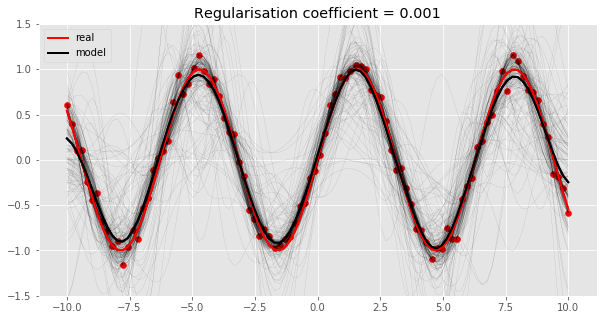

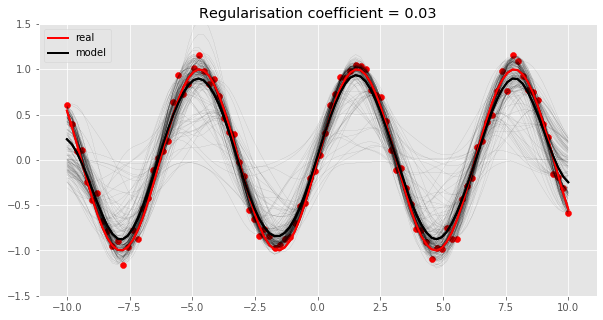

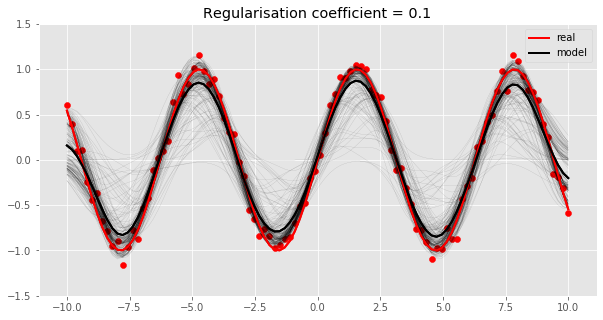

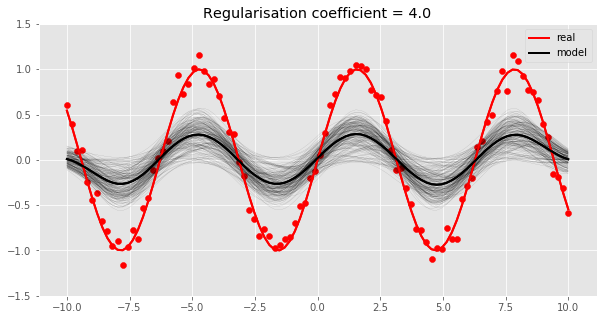

In [152]:
biases, variances, mses, ymses = [], [], [], []
# plt.figure(figsize=[4 *len(reg), 4])
for i, r in enumerate(reg):
    w = []
    # calculate w for 10 different datasets
    for _ in range(T):
        D = sample([Phi, y, x], n=N)
        w += [ml_estimate(D, r)]
    
    w = np.stack(w, 1)
    
    # caluclate statistics
    f_ = Phi @ w
    fm = f_.mean(-1)
    biases.append(sq_bias(f, fm))
    variances.append(var(f_, fm))
    mses.append(mse(f, f_))
    ymses.append(mse(y, f_))
    
    # visualise
    if i % 2 == 0:
        fig = plt.figure(figsize=[10., 5.])
        plt.title(f'Regularisation coefficient = {r}')
        plt.plot(x, f, 'r', linewidth=2.0)
        plt.plot(x, fm, 'k', linewidth=2.0)
        plt.plot(x, f_, 'k', linewidth=0.05)
        plt.ylim([-1.5, 1.5])
        plt.plot(x, f, 'r', linewidth=2.0)
        plt.plot(x, fm, 'k', linewidth=2.0)
        plt.ylim([-1.5, 1.5])
        plt.scatter(x, y, c='r')
        plt.legend(['real', 'model'])
        plt.savefig(f'ml-20-{r}.png', dpi=500)
f_ = Phi @ w

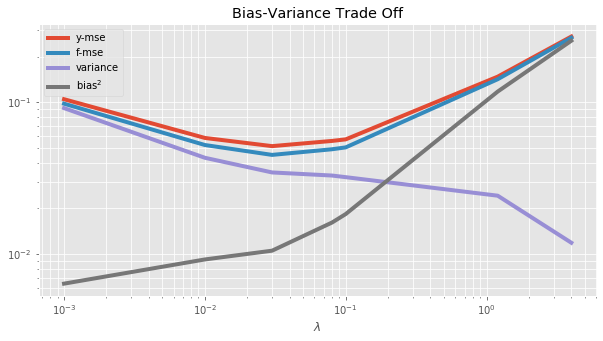

In [156]:
fig = plt.figure(figsize=[10., 5.])
plt.title('Bias-Variance Trade Off')
plt.loglog(reg, ymses, linewidth=4.0)
plt.loglog(reg, mses, linewidth=4.0)
plt.loglog(reg, variances, linewidth=4.0)
plt.loglog(reg, biases, linewidth=4.0)
plt.legend(['y-mse', 'f-mse', 'variance', 'bias$^2$'])
plt.grid(which='minor', axis='both')
plt.xlabel('$\lambda$')
plt.savefig(f'bias-variance.png', dpi=500)

### Bayesian Linear Regression

In [128]:
# hyper paramerts
alpha = 0.1   # initial guess for observation precision
beta = 0.1    # initial guess for weights precision
niters = 10

In [129]:
def bayesian_estimate(D, alpha=0.1, beta=0.1):
    Phi, y, *_ = D
    alphas = [alpha]
    betas = [beta]
    eig, _ = np.linalg.eig(Phi.T @ Phi)
    for i in range(5):
        Sn = np.linalg.inv(alpha * np.eye(M) + beta * Phi.T @ Phi)
        mn = beta * Sn @ Phi.T @ y
        gamma = np.sum(eig / (alpha + eig))
        # update
        alpha = gamma / (mn.T @ mn)
        beta = (N - gamma) * np.sum([(yy - mn.T @ phi) ** 2 for yy, phi in zip(y, Phi)]) ** -1
        alphas.append(gamma)
        betas.append(beta)
    return mn, Sn, alpha, beta

In [130]:
N = 20
D = sample([Phi, y, x], n=N)
# D = [Phi, y, x]
mn, Sn, alpha, beta = bayesian_estimate(D)

In [131]:
# estimate posterior predictive parameters
mu = Phi @ mn
sigma = 1 / beta + Phi @ Sn @ Phi.T
sd = np.sqrt(np.diag(sigma))

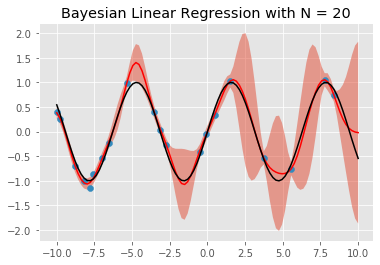

In [132]:
# generate figure
plt.title(f'Bayesian Linear Regression with N = {N}')
plt.fill_between(x, mu - 2 * sd, mu + 2 * sd, alpha=0.5)
plt.scatter(D[-1], D[-2])
plt.plot(x, mu, 'r')
plt.plot(x, f, 'k')
plt.show()